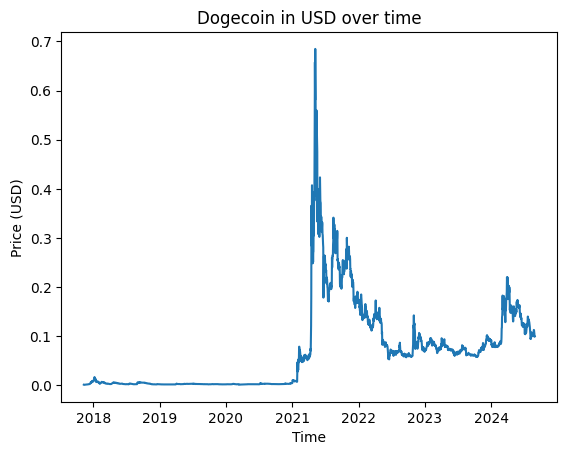

(2485, 4) (2485,)
Training Shape: (2236, 100, 4) (2236, 25)
Testing Shape: (126, 100, 4) (126, 25)
Training Shape: torch.Size([2236, 100, 4]) torch.Size([2236, 25])
Testing Shape: torch.Size([126, 100, 4]) torch.Size([126, 25])
Epoch: 0, train loss: 0.02963, test loss: 0.03801
Epoch: 10, train loss: 0.01674, test loss: 0.01653
Epoch: 20, train loss: 0.00655, test loss: 0.00254
Epoch: 30, train loss: 0.00414, test loss: 0.00365
Epoch: 40, train loss: 0.00301, test loss: 0.00153
Epoch: 50, train loss: 0.00240, test loss: 0.00219
Epoch: 60, train loss: 0.00213, test loss: 0.00127
Epoch: 70, train loss: 0.00204, test loss: 0.00130
Epoch: 80, train loss: 0.00198, test loss: 0.00111
Epoch: 90, train loss: 0.00194, test loss: 0.00112
Epoch: 100, train loss: 0.00191, test loss: 0.00110
Epoch: 110, train loss: 0.00188, test loss: 0.00115
Epoch: 120, train loss: 0.00185, test loss: 0.00115
Epoch: 130, train loss: 0.00181, test loss: 0.00120
Epoch: 140, train loss: 0.00177, test loss: 0.00128
Epo

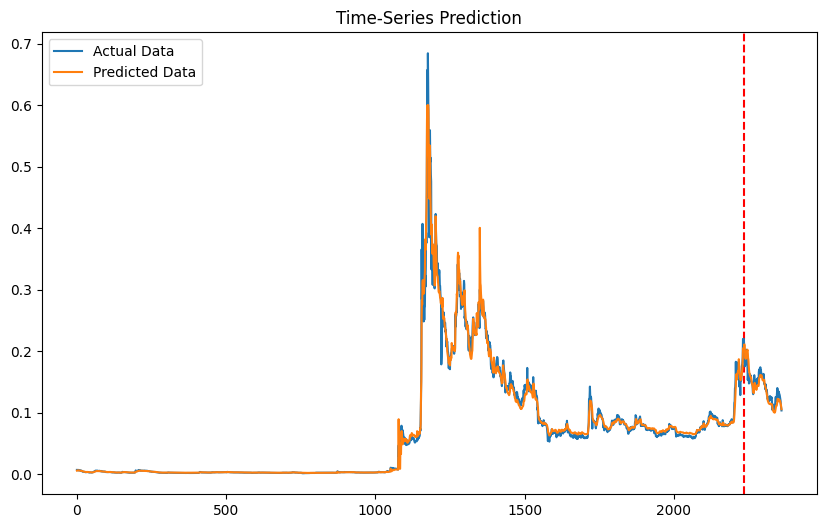

RMSE 0.010082518


In [1]:
"""
1) Importing libraries
"""
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings('ignore')
"""
2) Preprocessing the data
"""
df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/DOGE-USD?period1=1510185600&period2=1724853923&interval=1d&events=history&includeAdjustedClose=true', index_col = 'Date', parse_dates=True)
df.drop(columns=['Adj Close'], inplace=True)
df.head(5)

#plot the data
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.title("Dogecoin in USD over time")
plt.savefig("initial_plot.png", dpi=950)
plt.show()

#print shape of data
X, y = df.drop(columns=['Close']), df.Close.values
print(X.shape, y.shape)

mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

"""
3) Split the data into training and testing set
"""
# split a multivariate sequence past, future
# samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 100, 25)
#print(X_ss.shape, y_mm.shape)
assert y_mm[0].all() == y_trans[99:149].squeeze(1).all()
#print(y_mm[0])
#print(y_trans[99:149].squeeze(1))

total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:train_test_cutoff]
X_test = X_ss[train_test_cutoff:]

y_train = y_mm[:train_test_cutoff]
y_test = y_mm[train_test_cutoff:]

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape)

# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], 100,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], 100,
                                      X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape)

"""
4) LSTM model
"""
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=0.2) # lstm
        self.fc_1 =  nn.Linear(self.num_layers*hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.num_layers*self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out
"""
5) Training
"""
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train,
                  X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))

n_epochs = 250 # 1000 epochs
learning_rate = 0.0008 # 0.001 lr

input_size = 4 # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 25 # number of output classes

lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(),
                             lr=learning_rate)
#call the training loop function
training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

"""
6) Prediction
"""
df_X_ss = ss.transform(df.drop(columns=['Close'])) # old transformers
df_y_mm = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, 100, 25)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=train_test_cutoff, c='r', linestyle='--') # size of the training set

plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=1200)
plt.show()
print("RMSE", np.sqrt(np.mean((np.array(true) - np.array(preds))**2)))